In [1]:
# Imports
import numpy as np
from scipy.special import erf
from scipy.optimize import curve_fit, least_squares
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import interp1d
from astropy.table import Table
import matplotlib.colors as colors
from scipy.special import wofz
import spec
%matplotlib inline

In [9]:
def gaussbin(x, amp, cen, sig, const=0, dx=1.0):
    xcen = np.array(x)-cen             # relative to the center
    x1cen = xcen - 0.5*dx  # left side of bin
    x2cen = xcen + 0.5*dx  # right side of bin

    t1cen = x1cen/(np.sqrt(2.0)*sig)  # scale to a unitless Gaussian
    t2cen = x2cen/(np.sqrt(2.0)*sig)

    # For each value we need to calculate two integrals
    #  one on the left side and one on the right side

    # Evaluate each point
    #   ERF = 2/sqrt(pi) * Integral(t=0-z) exp(-t^2) dt
    #   negative for negative z
    geval_lower = erf(t1cen)
    geval_upper = erf(t2cen)

    geval = amp*np.sqrt(2.0)*sig * np.sqrt(np.pi)/2.0 * ( geval_upper - geval_lower )
    geval += const   # add constant offset

    return geval


def gaussian(x, amp, cen, sig, const=0):
    return amp * np.exp(-(x-cen)**2 / (2*sig**2)) + const


def gaussfit(x,y,initpar=None,sigma=None,bounds=(-np.inf,np.inf),binned=False):
    if initpar is None:
        initpar = [np.max(y),x[np.argmax(y)],1.0,np.median(y)]
    func = gaussian
    if binned is True: func=gaussbin
    return curve_fit(func, x, y, p0=initpar, sigma=sigma, bounds=bounds)


def voigt(x, height, cen, sigma, gamma, const=0.0, slp=0.0):

    maxy = np.real(wofz((1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)
    return (height/maxy) * np.real(wofz(((x-cen) + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi) + const + slp*(x-cen)


def voigtfit(x,y,initpar=None,sigma=None,bounds=(-np.inf,np.inf)):
    if initpar is None:
        initpar = [np.max(y),x[np.argmax(y)],1.0,1.0,np.median(y),0.0]
    func = voigt
    return curve_fit(func, x, y, p0=initpar, sigma=sigma, bounds=bounds)


def voigtarea(pars):
    sig = np.maximum(pars[2],pars[3])
    x = np.linspace(-20*sig,20*sig,1000)+pars[1]
    dx = x[1]-x[0]
    v = voigt(x,np.abs(pars[0]),pars[1],pars[2],pars[3])
    varea = np.sum(v*dx)
    return varea


def trace(im,yestimate=None,yorder=2,sigorder=4,step=10):
    ny,nx = im.shape
    if yestimate is None:
        ytot = np.sum(im,axis=1)
        yestimate = np.argmax(ytot)
    # Smooth in spectral dimension
    # a uniform (boxcar) filter with a width of 50
    smim = ndimage.uniform_filter1d(im, 50, 1)
    nstep = nx//step
    # Loop over the columns in steps and fit Gaussians
    tcat = np.zeros(nstep,dtype=np.dtype([('x',float),('pars',float,4)]))
    for i in range(nstep):
        pars,cov = gaussfit(y[yestimate-10:yestimate+10],im[yestimate-10:yestimate+10,step*i+step//2])
        tcat['x'][i] = step*i+step//2
        tcat['pars'][i] = pars
    # Fit polynomail to y vs. x and gaussian sigma vs. x
    ypars = np.polyfit(tcat['x'],tcat['pars'][:,1],yorder)
    sigpars = np.polyfit(tcat['x'],tcat['pars'][:,2],sigorder)
    # Model
    mcat = np.zeros(nx,dtype=np.dtype([('x',float),('y',float),('sigma',float)]))
    xx = np.arange(nx)
    mcat['x'] = xx
    mcat['y'] = np.poly1d(ypars)(xx)
    mcat['sigma'] = np.poly1d(sigpars)(xx)
    return tcat, ypars, sigpars,mcat


def boxcar(im):
    ny,nx = im.shape
    ytot = np.sum(im,axis=1)
    yest = np.argmax(ytot)
    # Background subtract
    yblo = int(np.maximum(yest-50,0))
    ybhi = int(np.minimum(yest+50,ny))
    med = np.median(im[yblo:ybhi,:],axis=0)
    medim = np.repeat(med,ny).reshape(ny,nx)
    subim = im.copy()-medim
    # Sum up the flux
    ylo = int(np.maximum(yest-20,0))
    yhi = int(np.minimum(yest+20,ny))
    flux = np.sum(subim[ylo:yhi,:],axis=0)
    return flux


def linefit(x,y,initpar,bounds,err=None):
    # Fit Gaussian profile to data with center and sigma fixed.
    # initpar = [height, center, sigma, constant offset]
    cen = initpar[1]
    sigma = initpar[2]
    def gline(x, amp, const=0):
        """1-D gaussian: gaussian(x, amp, cen, sig)"""
        return amp * np.exp(-(x-cen)**2 / (2*sigma**2)) + const
    line_initpar = [initpar[0],initpar[3]]
    lbounds, ubounds = bounds
    line_bounds = ([lbounds[0],lbounds[3]],[ubounds[0],ubounds[3]])
    return curve_fit(gline, x, y, p0=line_initpar, bounds=line_bounds, sigma=err)


def extract(im,imerr=None,mcat=None,nobackground=False):
    ny,nx = im.shape
    x = np.arange(nx)
    y = np.arange(ny)
    # No trace information input, get it
    if mcat is None:
        tcat,ypars,sigpars,mcat=trace(im)
    # Loop over the columns and get the flux using the trace information
    cat = np.zeros(nx,dtype=np.dtype([('x',int),('pars',float,2),('perr',float,2),
                                      ('flux',float),('fluxerr',float)]))
    for i in range(nx):
        line = im[:,i].flatten()
        if imerr is not None:
            lineerr = imerr[:,i].flatten()
        else:
            lineerr = np.ones(len(line))   # unweighted
        # Fit the constant offset and the height of the Gaussian
        #  fix the central position and sigma
        ycen = mcat['y'][i]
        ysigma = mcat['sigma'][i]
        ht0 = np.maximum(line[int(np.round(ycen))],0.01)
        initpar = [ht0,ycen,ysigma,np.median(line)]
        if nobackground is True:
            initpar = [ht0,ycen,ysigma,0]
        # Only fit the region right around the peak
        y0 = int(np.maximum(ycen-50,0))
        y1 = int(np.minimum(ycen+50,ny))
        bnds = ([0,ycen-1e-4,ysigma-1e-4,0],[1.5*ht0,ycen,ysigma,1.5*initpar[3]])
        if nobackground is True:
            bnds = ([0,ycen-1e-4,ysigma-1e-4,0],[1.5*ht0,ycen,ysigma,0.1])
        pars,cov = linefit(y[y0:y1],line[y0:y1],initpar=initpar,bounds=bnds,err=lineerr[y0:y1])
        perr = np.sqrt(np.diag(cov))
        # Gaussian area = ht*wid*sqrt(2*pi)
        flux = pars[0]*ysigma*np.sqrt(2*np.pi)
        fluxerr = perr[0]*ysigma*np.sqrt(2*np.pi)
        cat['x'][i] = i
        cat['pars'][i] = pars
        cat['perr'][i] = perr
        cat['flux'][i] = flux
        cat['fluxerr'][i] = fluxerr
    return cat


def emissionlines(spec,thresh=None):
    nx = len(spec)
    x = np.arange(nx)
    
    # Threshold
    if thresh is None:
        thresh = np.min(spec) + (np.max(spec)-np.min(spec))*0.05
    
    # Detect the peaks
    sleft = np.hstack((0,spec[0:-1]))
    sright = np.hstack((spec[1:],0))
    peaks, = np.where((spec>sleft) & (spec>sright) & (spec>thresh))
    npeaks = len(peaks)
    print(str(npeaks)+' peaks found')
    
    # Loop over the peaks and fit them with Gaussians
    gcat = np.zeros(npeaks,dtype=np.dtype([('x0',int),('x',float),('xerr',float),('pars',float,4),('perr',float,4),
                                           ('flux',float),('fluxerr',float)]))
    resid = spec.copy()
    gmodel = np.zeros(nx)
    for i in range(npeaks):
        x0 = peaks[i]
        xlo = np.maximum(x0-6,0)
        xhi = np.minimum(x0+6,nx)
        initpar = [spec[x0],x0,1,0]
        bnds = ([0,x0-3,0.1,0],[1.5*initpar[0],x0+3,10,1e4])
        pars,cov = gaussfit(x[xlo:xhi],spec[xlo:xhi],initpar,bounds=bnds,binned=True)
        perr = np.sqrt(np.diag(cov))
        gmodel1 = gaussian(x[xlo:xhi],*pars)
        gmodel[xlo:xhi] += (gmodel1-pars[3])
        resid[xlo:xhi] -= (gmodel1-pars[3])
        # Gaussian area = ht*wid*sqrt(2*pi)
        flux = pars[0]*pars[2]*np.sqrt(2*np.pi)
        fluxerr = perr[0]*pars[2]*np.sqrt(2*np.pi)
        gcat['x0'][i] = x0
        gcat['x'][i] = pars[1]
        gcat['xerr'][i] = perr[1]
        gcat['pars'][i] = pars
        gcat['perr'][i] = perr
        gcat['flux'][i] = flux
        gcat['fluxerr'][i] = fluxerr
        #print(str(i+1)+' '+str(x0)+' '+str(pars))
        
    return gcat, gmodel


def continuum(spec,bin=50,perc=60,norder=4):
    nx = len(spec)
    x = np.arange(nx)
    # Loop over bins and find the maximum
    nbins = nx//bin
    xbin1 = np.zeros(nbins,float)
    ybin1 = np.zeros(nbins,float)
    for i in range(nbins):
        xbin1[i] = np.mean(x[i*bin:i*bin+bin])
        ybin1[i] = np.percentile(spec[i*bin:i*bin+bin],perc)
    # Fit polynomial to the binned values
    coef1 = np.polyfit(xbin1,ybin1,norder)
    cont1 = np.poly1d(coef1)(x)
    
    # Now remove large negative outliers and refit
    gdmask = np.zeros(nx,bool)
    gdmask[(spec/cont1)>0.8] = True
    xbin = np.zeros(nbins,float)
    ybin = np.zeros(nbins,float)
    for i in range(nbins):
        xbin[i] = np.mean(x[i*bin:i*bin+bin][gdmask[i*bin:i*bin+bin]])
        ybin[i] = np.percentile(spec[i*bin:i*bin+bin][gdmask[i*bin:i*bin+bin]],perc)
    # Fit polynomial to the binned values
    coef = np.polyfit(xbin,ybin,norder)
    cont = np.poly1d(coef)(x)
    
    return cont,coef

In [2]:
ls data\spec_analysis_data

 Volume in drive C is OS
 Volume Serial Number is 4E89-5B0C

 Directory of C:\Users\WillsPc\GitHub\ObservationalAstro_PHSX491\inclass_activities\data\spec_analysis_data

12/15/2021  04:13 PM    <DIR>          .
12/15/2021  04:13 PM    <DIR>          ..
11/30/2021  09:33 AM    <DIR>          __MACOSX
11/30/2021  09:33 AM            15,524 spec.t10000g3.00m-1.00.fits.gz
11/30/2021  09:33 AM            15,679 spec.t10000g4.00m+0.00.fits.gz
11/30/2021  09:33 AM            15,711 spec.t10000g4.00m+0.50.fits.gz
11/30/2021  09:33 AM            15,633 spec.t10000g4.00m-0.50.fits.gz
11/30/2021  09:33 AM            15,647 spec.t10000g4.00m-1.00.fits.gz
11/30/2021  09:33 AM            15,596 spec.t10000g4.00m-1.50.fits.gz
11/30/2021  09:33 AM            15,636 spec.t10000g4.50m-1.00.fits.gz
11/30/2021  09:33 AM            15,721 spec.t10000g5.00m-1.00.fits.gz
11/30/2021  09:33 AM            15,567 spec.t12000g4.00m+0.00.fits.gz
11/30/2021  09:33 AM            15,554 spec.t12000g4.00m-0.50.fits.gz

In [3]:
path = './data/spec_analysis_data/'

In [4]:
spec1,head1 = fits.getdata(path + 'specHD7795.fits',header=True)
wave1 = np.arange(head1['NAXIS1'])*head1['CDELT1']+head1['CRVAL1']
if head1['DC-FLAG']==1:
    wave1 = 10**wave1

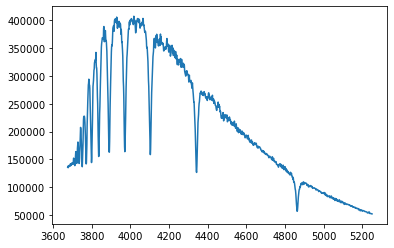

In [5]:
plt.plot(wave1,spec1)

In [6]:
spec2,head2 = fits.getdata(path + 'specDI1526.fits',header=True)
wave2 = np.arange(head2['NAXIS1'])*head2['CDELT1']+head2['CRVAL1']
if head2['DC-FLAG']==1:
    wave2 = 10**wave2

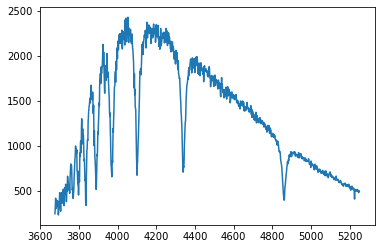

In [7]:
plt.plot(wave2,spec2)

In [8]:
? spec.*

# Continuum normalize

In [10]:
cont1,coef1 = continuum(spec1)

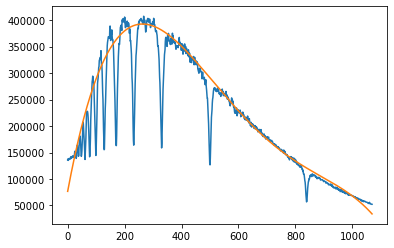

In [11]:
plt.plot(spec1)
plt.plot(cont1)

In [12]:
nspec1 = spec1/cont1

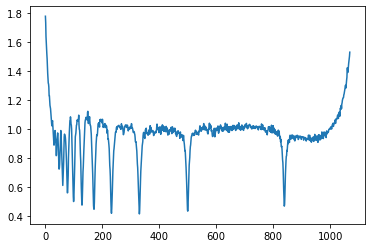

In [13]:
plt.plot(nspec1)

In [14]:
cont2,coef2 = continuum(spec2)

In [15]:
nspec2 = spec2/cont2

(0.0, 1.5)

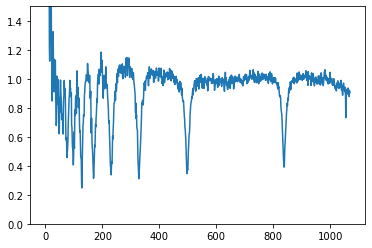

In [16]:
plt.plot(nspec2)
plt.ylim(0,1.5)

In [17]:
wave1-wave2

array([0., 0., 0., ..., 0., 0., 0.])

(0.0, 1.2)

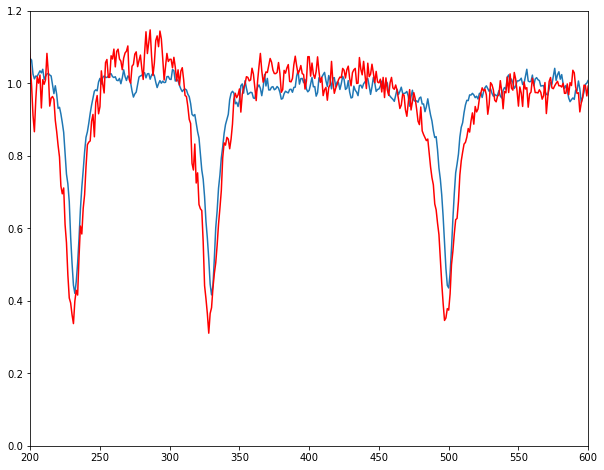

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(nspec1)
plt.plot(nspec2,'r')
plt.xlim(200,600)
plt.ylim(0,1.2)

In [19]:
def ccorrelate(x,y,lag):
    """ Cross-Correlation"""
    nx = len(x)
    # Subract mean values
    xd = x-np.mean(x)
    yd = y-np.mean(y)
    nlag = len(lag)
    cross = np.zeros(nlag,dtype=float)
    # Loop over lag points
    for k in range(nlag):
        # Note the reversal of the variables for negative lags.
        if lag[k]>0:
            cross[k] = np.sum(xd[0:nx-lag[k]] * yd[lag[k]:])
        else:
            cross[k] =  np.sum(yd[0:nx+lag[k]] * xd[-lag[k]:])
    cross /= np.sqrt(np.sum(xd**2)*np.sum(yd**2))
    return cross

In [20]:
lag = np.arange(101)-50
print(lag)

[-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50]


In [21]:
lag = np.arange(101)-50
cc = ccorrelate(nspec1[200:600],nspec2[200:600],lag)

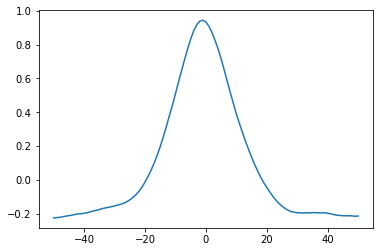

In [22]:
plt.plot(lag,cc)

(0.6, 1.0)

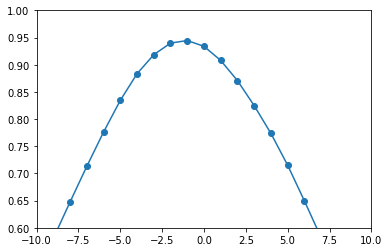

In [23]:
plt.plot(lag,cc)
plt.scatter(lag,cc)
plt.xlim(-10,10)
plt.ylim(0.6,1)

In [24]:
lag[np.argmax(cc)]

-1

In [25]:
pars,cov = gaussfit(lag[40:60],cc[40:60])
gmodel = gaussian(lag,*pars)
print(pars)

[ 0.81522336 -1.01723724  7.37251612  0.12772564]


(0.6, 1.0)

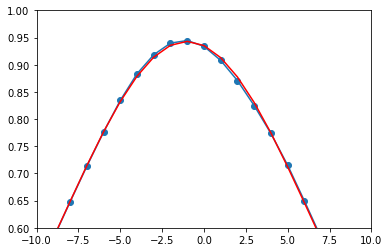

In [26]:
plt.plot(lag,cc)
plt.scatter(lag,cc)
plt.plot(lag,gmodel,'r')
plt.xlim(-10,10)
plt.ylim(0.6,1)

# Synthetic spectra

In [27]:
wave1

array([3675.        , 3676.22637897, 3677.45316719, ..., 5246.49781326,
       5248.2486145 , 5250.        ])

## Color-Temperature Relationship

In [28]:
coef = [-0.452476, 1.27735, -1.16871, 0.885106, 0.507745]

In [29]:
# From Simbad, HD7795 has B-V=-0.080
# From Demers & Irwin (1990) DI1526 has B-V=-0.12

In [30]:
print(5040.0/np.poly1d(coef)(-0.08))
print(5040.0/np.poly1d(coef)(-0.12))

11754.163369558193
13179.855320606526


## 6000 K

In [31]:
sp = fits.getdata(path + 'spec.t6000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

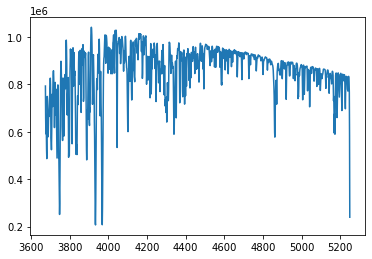

In [32]:
plt.plot(w,sp['flux'])

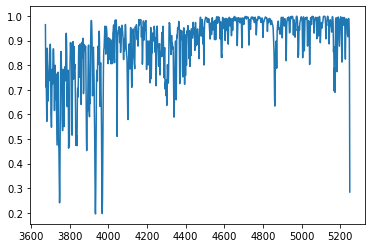

In [33]:
plt.plot(w,sp['flux']/sp['cont'])

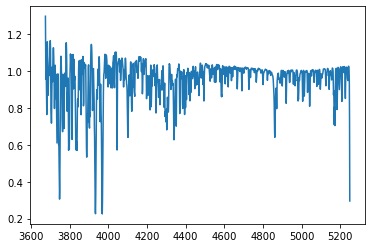

In [34]:
plt.plot(w,s2)

(0.0, 1.2)

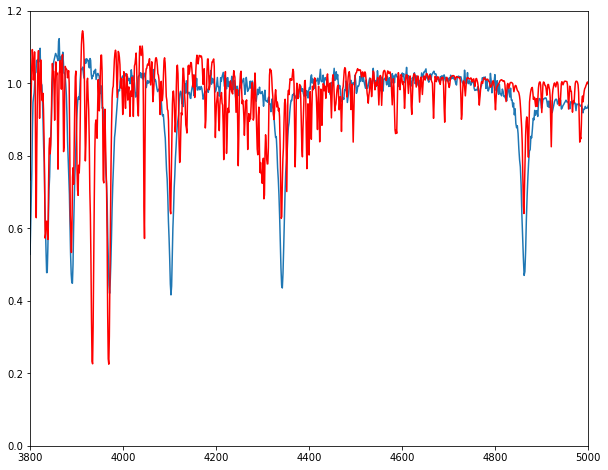

In [35]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 8000 K

In [36]:
sp = fits.getdata(path + 'spec.t8000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

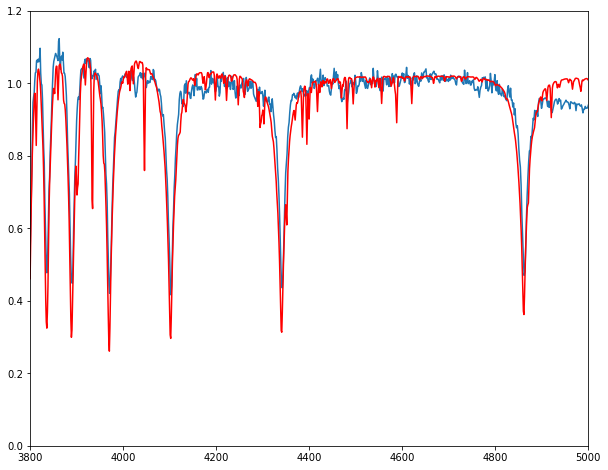

In [37]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 10000 K

In [38]:
sp = fits.getdata(path + 'spec.t10000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

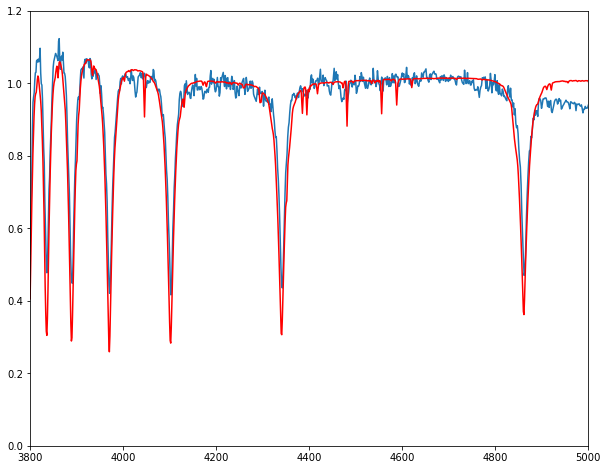

In [39]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 12000 K

In [40]:
sp = fits.getdata(path + 'spec.t12000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

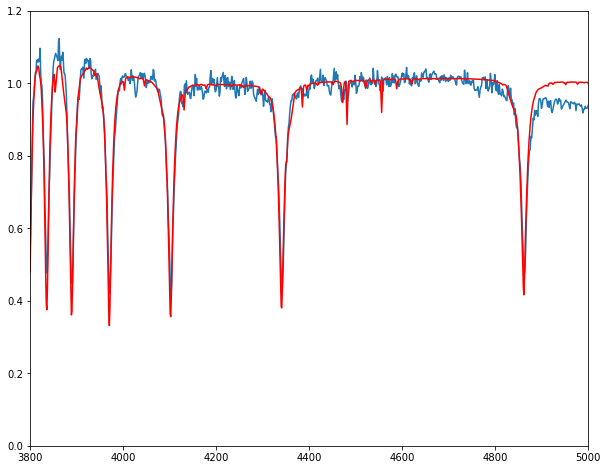

In [41]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 14000 K

In [42]:
sp = fits.getdata(path + 'spec.t14000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

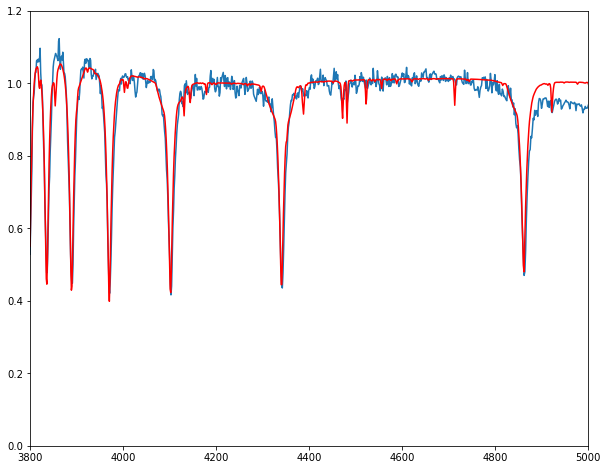

In [43]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = 0.0

In [44]:
sp = fits.getdata(path + 'spec.t12000g4.00m+0.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

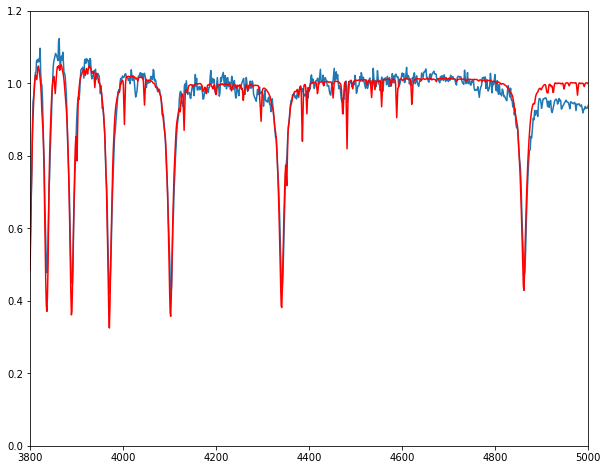

In [45]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -0.5

In [46]:
sp = fits.getdata(path + 'spec.t12000g4.00m-0.50.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

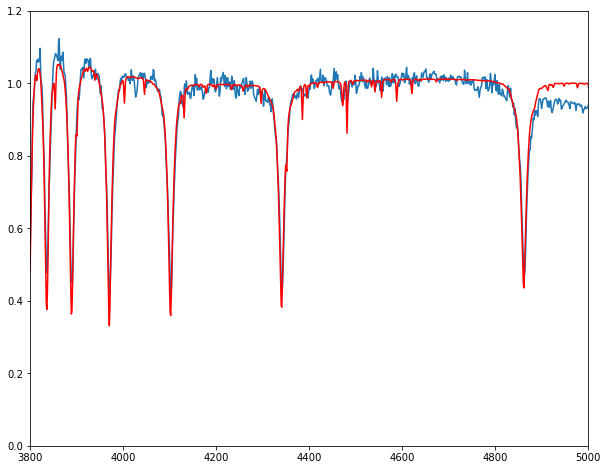

In [47]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -1.0

In [48]:
sp = fits.getdata(path + 'spec.t12000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

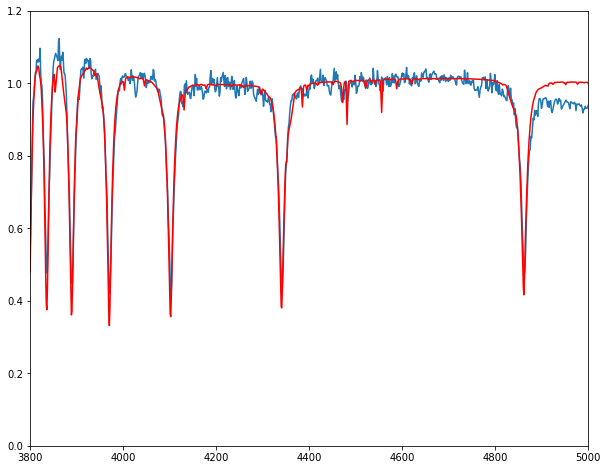

In [49]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -1.5

In [50]:
sp = fits.getdata(path + 'spec.t12000g4.00m-1.50.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

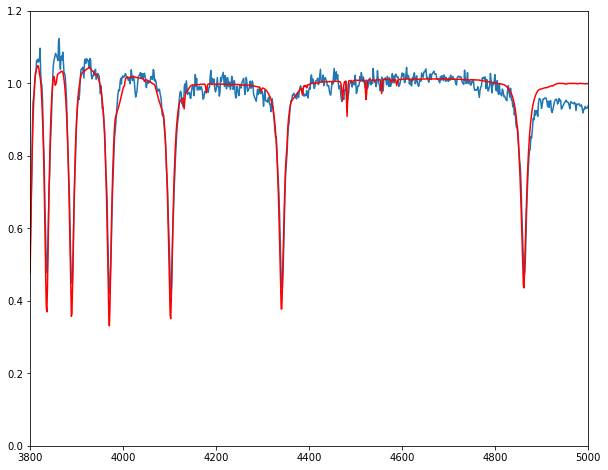

In [51]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -2.0

In [52]:
sp = fits.getdata(path + 'spec.t12000g4.00m-2.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

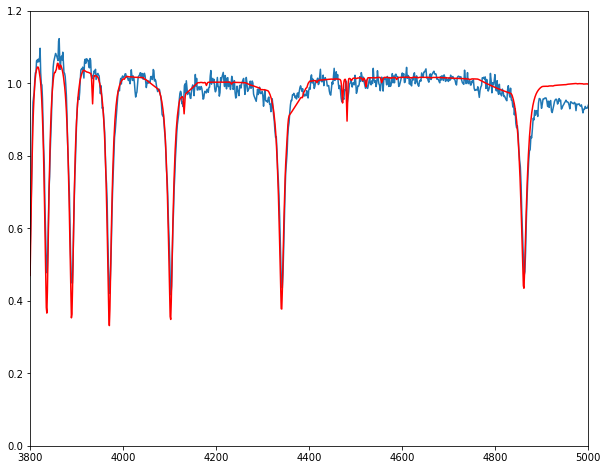

In [53]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

In [54]:
sp = fits.getdata(path + 'spec.t10000g3.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

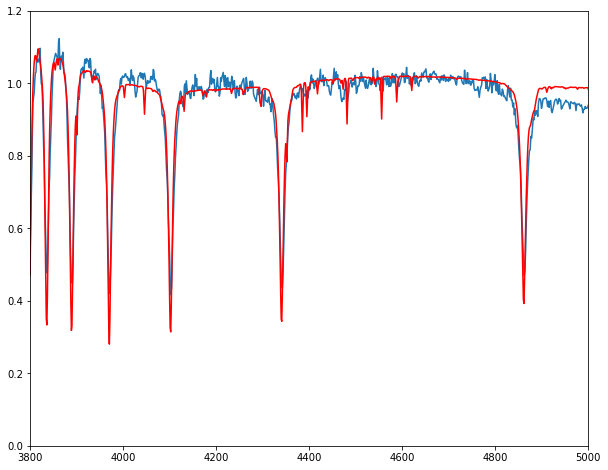

In [55]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

In [56]:
sp = fits.getdata(path + 'spec.t10000g5.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = continuum(s)
s2 = s/c

(0.0, 1.2)

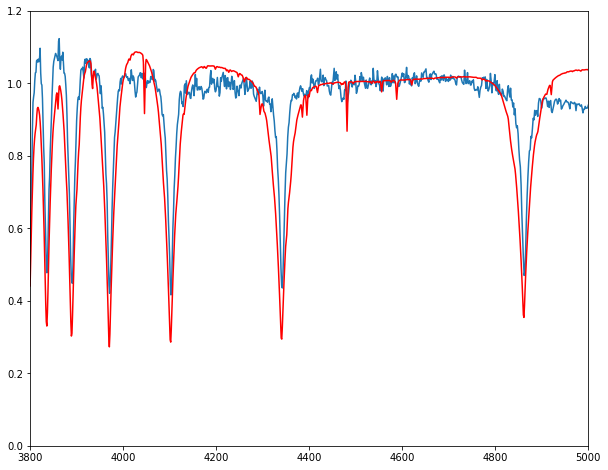

In [57]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)